# Config

# Testing endpoint for various execution providers

### dummy data

In [2]:
import requests

import base64
import numpy as np
import scipy.io  as io
import pandas as pd 
import time 
import os 
import subprocess 
from subprocess import Popen, PIPE


path = "/home/akinwilson/Code/pytorch/dataset/keywords/yes/yes.f5626af6_nohash_2.wav"
train_df_path = "/home/akinwilson/Code/pytorch/dataset/keywords/train.csv"
df = pd.read_csv(train_df_path).sample(n=100)

def encode_wav(path):
    _, wav = io.wavfile.read(path)
    wav
    s = base64.b64encode(wav)
    return s 

# load input data 
data_list = [{'base64str': encode_wav(path).decode('utf-8')} for path in df.wav_path]
exec_and_container_name = [("CUDAExecutionProvider", "testgpu"), ("CPUExecutionProvider", "testcpu"),("TensorrtExecutionProvider", "testrt")]

def init_backend(executioner, executioner_name):
    cmd = f'docker run --gpus all -p 8080:80 -e "WORKERS=1" -e "EXECUTION_PROVIDER={executioner}" --name="{executioner_name}" serve:latest'
    # subprocess.call(cmd, shell=True)  
    cmd_list= cmd.split()
    print(cmd_list)
    p = subprocess.Popen(cmd_list, stdout=subprocess.PIPE)
    out, err = p.communicate()
    print(out)
    t = 10
    print(f"Sleeping for {t} seconds to allow the backend using {executioner} to spin up")
    time.sleep(t)



def stop_backend(executioner):
    print(f"Stopping container {executioner}")
    subprocess.call(f'docker stop {executioner}', shell=True) 
    time.sleep(1)
    print(f"Removing container {executioner}") 
    subprocess.call(f'docker rm {executioner}', shell=True)
    time.sleep(1)



In [ ]:
init_backend(*exec_and_container_name[0])

### 

In [3]:
def send_request(data):
    url = 'http://0.0.0.0:8080/api/v1/predict'
    x = requests.post(url, json = data)
    return x.json()


import multiprocessing as mp
import time
latency_results = []

for process_count in range(1, 40):
    pool = mp.Pool(processes=process_count)
    s = time.time()
    results = pool.map(send_request, data_list)
    f = time.time()
    print(f"Sent {len(data_list)} queries in {f-s} seconds")
    print(f"QPS: {(len(data_list) / (f-s) ):.2f}")
    inf_times = [result['result']['inference_time'] for result in results] 
    avg_inf = sum(inf_times) / len(inf_times)
    print(f"Avg inference time: {avg_inf}")
    exec = "CPU"
    latency_results.append( {
        "Executioner": exec,
        "process_count":process_count,
        "average_inference_time": avg_inf, 
        "QPS": len(data_list) / (f-s),
    })
import json

with open(f"latency_result_{exec}.list", "w") as file:
    file.write(json.dumps(latency_results))


Sent 100 queries in 10.76884126663208 seconds
QPS: 9.29
Avg inference time: 0.10247692108154297
Sent 100 queries in 8.16280722618103 seconds
QPS: 12.25
Avg inference time: 0.15124895572662353
Sent 100 queries in 6.424834966659546 seconds
QPS: 15.56
Avg inference time: 0.1717548656463623
Sent 100 queries in 6.318666696548462 seconds
QPS: 15.83
Avg inference time: 0.22263858556747437
Sent 100 queries in 6.0048112869262695 seconds
QPS: 16.65
Avg inference time: 0.28318647146224973
Sent 100 queries in 6.065261363983154 seconds
QPS: 16.49
Avg inference time: 0.3204184865951538
Sent 100 queries in 5.953427314758301 seconds
QPS: 16.80
Avg inference time: 0.3715604043006897
Sent 100 queries in 5.899148464202881 seconds
QPS: 16.95
Avg inference time: 0.4237077760696411
Sent 100 queries in 5.592055559158325 seconds
QPS: 17.88
Avg inference time: 0.47301790475845334
Sent 100 queries in 5.527585983276367 seconds
QPS: 18.09
Avg inference time: 0.5058519053459167
Sent 100 queries in 5.39959931373596

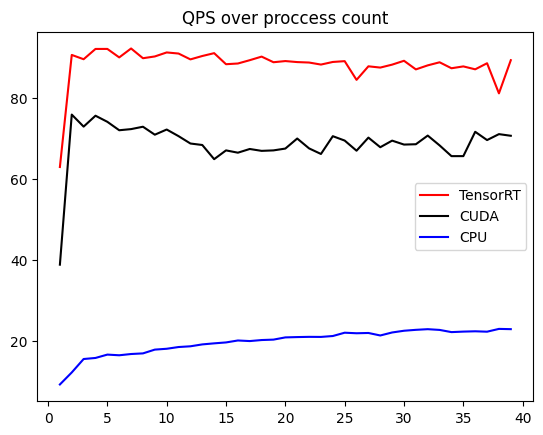

In [16]:
lat_result_path = [
    "/home/akinwilson/Code/pytorch/notebooks/latency_result_TensorRT.list",
    "/home/akinwilson/Code/pytorch/notebooks/latency_result_CUDA.list",
    "/home/akinwilson/Code/pytorch/notebooks/latency_result_CPU.list"
]
import pandas as pd 
import matplotlib.pyplot as plt

def get_df(path=lat_result_path[2]):
    with open(path, "r") as f:
        df = pd.DataFrame.from_records(json.loads(f.read()))
    return df 
get_df()

def plot_comparing(col='average_inference_time'):
    to_plot = {p.split(".")[0].split("_")[-1]: get_df(p) for p in lat_result_path}
    
    plt.title(f"{col} over proccess count")
    for idx, (k,v) in enumerate(to_plot.items()):
        cs = {0:"r", 1:"k", 2:"b"}
        plt.plot(v.process_count.tolist(), v[col].tolist(), cs[idx], label=k) # plotting t, a separately 
        plt.legend()


plot_comparing(col='QPS')

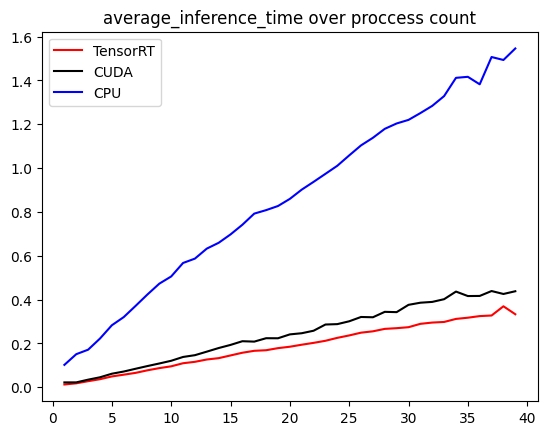

In [17]:
plot_comparing(col='average_inference_time')


In [ ]:
path = "/home/akinwilson/Code/pytorch/dataset/data/000a5b70-dfe9-4bf5-9199-85feb935bfdb.wav"

from scipy.io import wavfile
import base64 

samplerate, data = wavfile.read(path)


txt = base64.b64encode(data)

# with open("bas64.example", "wb") as file:
#     file.write(txt)

import numpy as np 

decoded_wav = base64.decodebytes(txt)
x = np.frombuffer(decoded_wav, dtype=np.int16)
x.shape


In [ ]:
import os 

print()

## Testing onnx runtime

 Issue with CUDA as exection provider. 

 see: 
 
    https://stackoverflow.com/questions/70014477/onnxruntime-not-using-cuda

In [ ]:
ort_session.get_providers()

In [ ]:
import onnx 

# path= "/home/akinwilson/Code/pytorch/output/model/DeepSpeech/2022_09_12_11.22.09_AM/export/DeepSpeech.onnx"

# p = "/home/akinwilson/Code/pytorch/output/model/DeepSpeech/2022_09_12_11.22.09_AM/inference/DeepSpeech.pt"

import onnxruntime
import torch 
import time 
import logging 
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

x = torch.randn(1, 1, 48000, device='cpu')
s = time.time()


In [ ]:
# import onnxruntime as ort
# ort.get_all_providers()
# ort.get_device()

In [ ]:
# import onnxruntime
# import torch 
# import time 
# onnxruntime.get_providers()

In [ ]:
# p = "/home/akinwilson/Code/pytorch/output/model/DeepSpeech/2022_09_12_11.22.09_AM/inference/DeepSpeech.pt"
# import torch 
# import time 
# # model = torch.load(p)
# s= time.time()
# model.forward(x)
# f = time.time()
# print(f"Serving python: {(f-s)* 1e3:.5f}ms")